In [12]:
!pip install gower
!pip install xgboost

In [202]:
import pandas as pd
import numpy as np
# visual
import matplotlib.pyplot as plt
import seaborn as sns
# distance
import gower
# sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.metrics import confusion_matrix, rand_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

## Import Data

In [14]:
lst_str_cols = ['move']
dict_dtypes = {x: 'str' for x in lst_str_cols}
data = pd.read_csv('preprocessed_encoded_rocket_league_skillshots.csv', dtype=dict_dtypes)
df = pd.DataFrame(data = data)
df = df.drop(['Unnamed: 0'], axis = 1)

In [15]:
df.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,goal,Class,move
0,0.005129,0.000000,0.012304,0.498266,0.031512,0.453337,0.300277,0,6,3
1,0.010021,0.010311,0.012290,0.498266,0.024175,0.540209,0.309974,0,6,22
2,0.000000,0.012889,0.012290,0.498266,0.024959,0.540209,0.312201,0,6,18
3,0.031069,0.023200,0.012311,0.498266,0.015971,0.501078,0.342262,0,6,2
4,0.018512,0.046400,0.012387,0.498271,0.016252,0.543875,0.360175,0,6,3


In [16]:
df['move'].dtypes

dtype('O')

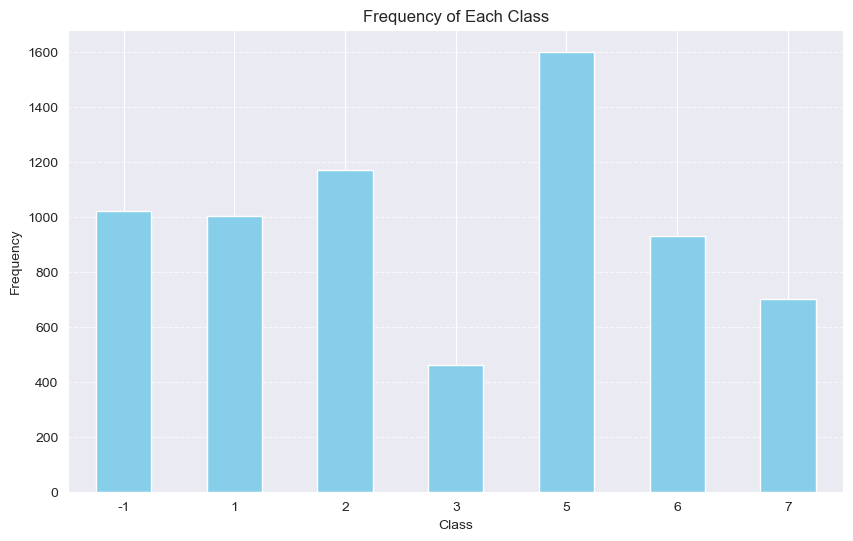

In [17]:
# Plotting the histogram of the frequency of each class including -1
plt.figure(figsize=(10, 6))
df['Class'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the class labels horizontal for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [18]:
df_no_target = df.drop(columns=['Class'])

# Agglomerative Clustering

In [19]:
model = AgglomerativeClustering(n_clusters = 7, affinity = 'precomputed')

In [20]:
target = df[['Class']]
le = LabelEncoder()

labeled_target = target.apply(le.fit_transform)

labels = pd.DataFrame()
labels['target'] = labeled_target.values.reshape(1, -1).tolist()[0]


## Trying three different kinds of linkages for agglomerative clustering

### Single Linkage

In [21]:
model_single_linkage = AgglomerativeClustering(n_clusters = 7, linkage= 'single', metric = 'precomputed')
clusters_single_linkage = model_single_linkage.fit_predict(gower_matrix)

NameError: name 'gower_matrix' is not defined

In [22]:
labels['single_linkage_predictions'] = clusters_single_linkage

NameError: name 'clusters_single_linkage' is not defined

In [23]:
sri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_single_linkage)
print(f'Rand Index: {sri}')

NameError: name 'clusters_single_linkage' is not defined

In [24]:
labels[['single_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

KeyError: "None of [Index(['single_linkage_predictions'], dtype='object')] are in the [columns]"

This shows that all the data has fallen under one cluster. This is not a good representation of the data

## Average Clustering

In [25]:
model_average_linkage = AgglomerativeClustering(n_clusters = 7, linkage = 'average', metric = 'precomputed')
clusters_average_linkage = model_average_linkage.fit_predict(gower_matrix)

NameError: name 'gower_matrix' is not defined

In [26]:
labels['average_linkage_predictions'] = clusters_average_linkage

NameError: name 'clusters_average_linkage' is not defined

In [27]:
ari = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_average_linkage)
print(f'Rand Index: {ari}')

NameError: name 'clusters_average_linkage' is not defined

In [28]:
labels[['average_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

KeyError: "None of [Index(['average_linkage_predictions'], dtype='object')] are in the [columns]"

The number of classes representing each type of data is diversifying but still the classes are being represented well.

## Complete Linkage

In [29]:
model_complete_linkage = AgglomerativeClustering(n_clusters=7, linkage = 'complete', metric= 'precomputed')
clusters_complete_linkage = model_complete_linkage.fit_predict(gower_matrix)

NameError: name 'gower_matrix' is not defined

In [30]:
labels['complete_linkage_predictions'] = clusters_complete_linkage

NameError: name 'clusters_complete_linkage' is not defined

In [31]:
cri = rand_score(labeled_target.values.reshape(1, -1)[0], clusters_complete_linkage)
print(f'Rand Index: {cri}')

NameError: name 'clusters_complete_linkage' is not defined

In [32]:
labels[['complete_linkage_predictions']].value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

KeyError: "None of [Index(['complete_linkage_predictions'], dtype='object')] are in the [columns]"

In [33]:
labels.value_counts(["target", "complete_linkage_predictions"])

KeyError: 'complete_linkage_predictions'

In [ ]:
labels['aligned_clusters'] = labels['complete_linkage_predictions'].apply(lambda x: int(not x))

In [ ]:
cf_matrix = confusion_matrix(labeled_target.values, labels[["aligned_clusters"]].values)
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
fig, ax = plt.subplots(1, 1)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=cf_labels, fmt='', cmap='Blues')
ax.set_ylabel('Target Labels')
ax.set_xlabel('Predicted Labels')

# Classification

In [36]:
df_target = df[['Class']]
df_no_target.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,goal,move
0,0.005129,0.000000,0.012304,0.498266,0.031512,0.453337,0.300277,0,3
1,0.010021,0.010311,0.012290,0.498266,0.024175,0.540209,0.309974,0,22
2,0.000000,0.012889,0.012290,0.498266,0.024959,0.540209,0.312201,0,18
3,0.031069,0.023200,0.012311,0.498266,0.015971,0.501078,0.342262,0,2
4,0.018512,0.046400,0.012387,0.498271,0.016252,0.543875,0.360175,0,3


In [37]:
# train test split data 80%-20%

X = df_no_target
y = df['Class']

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Decision Tree Classifier

In [182]:
param_grid = {
    'criterion':["gini","entropy"],
    'max_depth': [1000],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 3,4, 5]
}

In [183]:
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(dtree, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

C:\Tools\conda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Tools\conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Tools\conda\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Tools\conda\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Tools\conda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1000],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3, 4, 5]})

In [184]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [191]:
dtree = DecisionTreeClassifier(max_depth = 1000).fit(X_train, y_train)
# dtree = DecisionTreeClassifier(max_depth = 1000).fit(X_train, y_train)

dtree_prediction = dtree.predict(X_test)

In [192]:
# from sklearn import tree
# classes = ['noise', 'ceiling shot', 'power shot', 'waving dash', 'air dribble', 'front flick', 'musty flick']
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtree,
#                    feature_names=X.columns.tolist(),
#                    class_names= classes,
#                    filled=True)

In [193]:
cm = confusion_matrix(y_test, dtree_prediction)

In [194]:
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

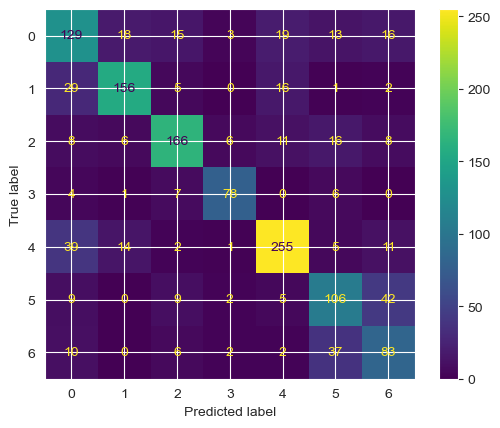

In [195]:
cm_graph.plot()
plt.show()

In [196]:
print(classification_report(y_test, dtree_prediction))

              precision    recall  f1-score   support

          -1       0.57      0.61      0.59       213
           1       0.80      0.75      0.77       209
           2       0.79      0.75      0.77       221
           3       0.85      0.81      0.83        96
           5       0.83      0.78      0.80       327
           6       0.58      0.61      0.59       173
           7       0.51      0.59      0.55       140

    accuracy                           0.71      1379
   macro avg       0.70      0.70      0.70      1379
weighted avg       0.71      0.71      0.71      1379


## Random Forest Classifier

In [198]:
forest = RandomForestClassifier(max_depth = 1000, random_state = 0).fit(X_train, y_train)
forest_prediction = forest.predict(X_test) 

In [199]:
cm = confusion_matrix(y_test, forest_prediction)

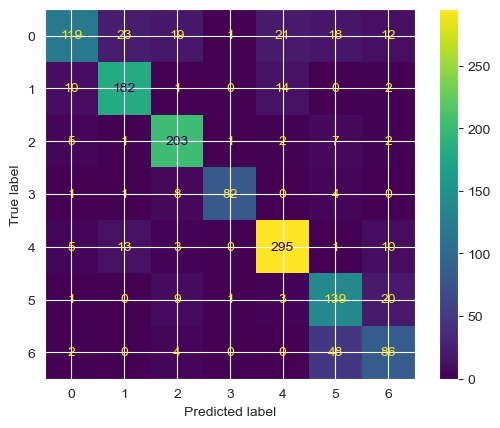

In [200]:
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_graph.plot()
plt.show()

In [201]:
print(classification_report(y_test, forest_prediction))

              precision    recall  f1-score   support

          -1       0.83      0.56      0.67       213
           1       0.83      0.87      0.85       209
           2       0.82      0.92      0.87       221
           3       0.96      0.85      0.91        96
           5       0.88      0.90      0.89       327
           6       0.64      0.80      0.71       173
           7       0.65      0.61      0.63       140

    accuracy                           0.80      1379
   macro avg       0.80      0.79      0.79      1379
weighted avg       0.81      0.80      0.80      1379


## Support Vector Machine (SVM)

### Support Vector Classification (SVC)

In [204]:
svc = SVC(kernel = 'rbf', gamma = 0.5, C = 1.0)
svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)

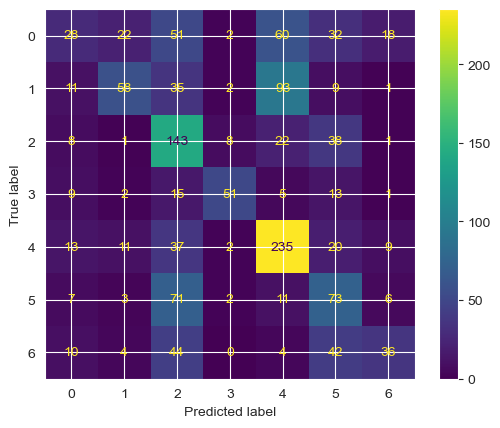

In [205]:
cm = confusion_matrix(y_test, svc_predictions)
cm_graph = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_graph.plot()
plt.show()

### Nu-Support Vector Classification (NuSVC)

### Linear Support Vector Classification